# Определение возраста покупателей

## Цель и задачи исследования


**Заказчик исследования:** сетевой супермаркет.

**Цель:** построить модель для определения возраста покупателей по фотографиям в прикассовой зоне.

**Критерий качества модели**: метрика *MAE* менее 8 (в идеале - менее 7).

**Задачи (этапы) исследования:**
1. Провести загрузку и исследовательский анализ данных:
- загрузить данные;
- провести общий обзор;
- построить график распределения возраста в выборке;
- вывести 10–15 фотографий.
2. Повести подготовку данных к обучению.
3. Построить модель определения возраста :
- построить модель на основе нейросети;
- рассчитать для модели метрику *MAE* на тестовой выборке.
4. Сформулировать общие выводы.

## Описание данных

- Папка с изображениями: /final_files
- CSV-файл labels.csv с двумя колонками: file_name и real_age.

## Импорт библиотек

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
SEED = 42

## Загрузка данных

In [ ]:
labels = pd.read_csv('...')

train_datagen = ImageDataGenerator(rescale=1./255)

train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='...',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [ ]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [ ]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Датасет содержит 7591 фотографию.

На всякий случай проверим наличие дубликатов.

In [ ]:
labels.duplicated().sum()

0

In [ ]:
labels['file_name'].duplicated().sum()

0

Дубликаты отсутствуют.

## Исследовательский анализ данных

### Распределение возраста

Построим график распределения возраста в выборке.

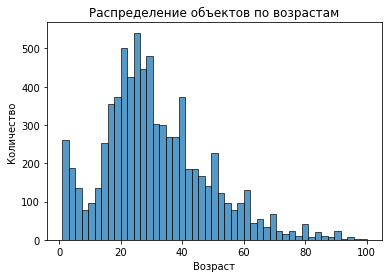

In [ ]:
sns.histplot(data=labels, x='real_age')\
.set(title='Распределение объектов по возрастам',
     xlabel='Возраст',
     ylabel='Количество');

Выведем описательную статистику.

In [ ]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Наибольшая доля объектов имеет возраст 29 лет. При этом встречаются как младенцы (минимальный возраст - 1 год), так и совсем пожилые (100 лет).

### Анализ фотографий

Выведем 15 случайных фотографий.

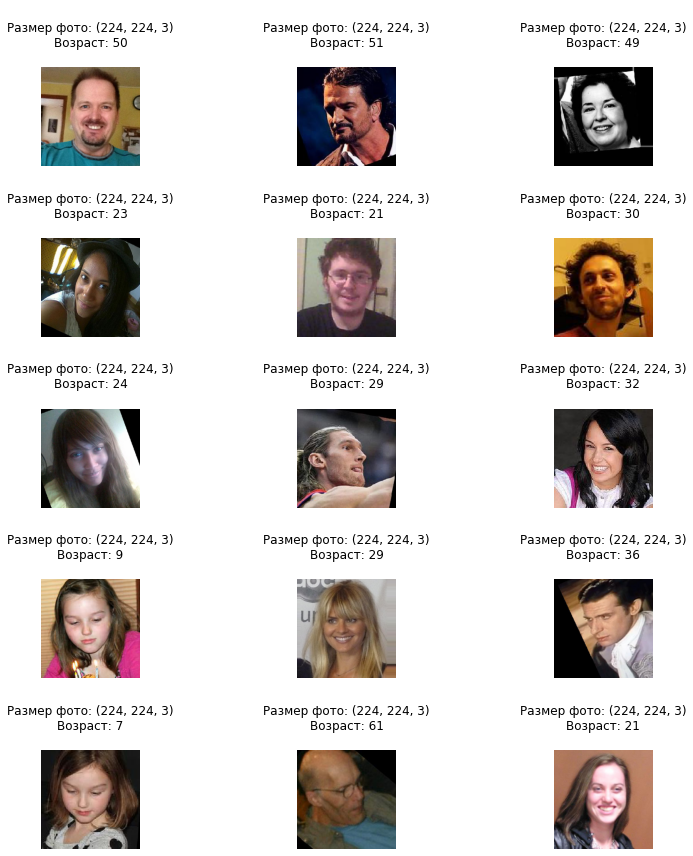

In [ ]:
plt.figure(figsize = (12,12))

for i in range(15):
    img, label = train_gen_flow.next()
    ax = plt.subplot(5, 3, i+1)
    ax.set_title(
        '\nРазмер фото: ' + str(img[0].shape) + '\n' +
        'Возраст: ' + str(label[0]) + '\n'
    )
    plt.axis('off')
    plt.imshow(img[0])

plt.tight_layout()
plt.show()

Представлены фотографии различного качества, с разным углом наклона (до 45 градусов). Все фотографии имеют одинаковую размерность как по ширине и высоте (224), так и по числу каналов (3), даже несмотря на то, что отдельные фотографии по факту представлены в градациях серого. На всех фотографиях основную площадь занимает лицо.

На ряде фотографий виден черный фон (видимо, вследствие поворота), на некоторых - в кадре два лица.

### Промежуточный вывод

Результаты проведенного анализа:
- в датасете представлена 7591 фотография;
- все фотографии имеют одинаковую размерность;
- наибольшая доля объектов имеет возраст 29 лет, явных выбросов не отмечается;
- фотографии имеют различное качество и разные углы наклона, также различаются цветовой гаммой, фоном, резкостью и и т.д.

Для качественного обучения модели потребуется аугментация:
- изменение масштаба;
- сдвиги по ширине и высоте;
- отражение по горизонтали.

При этом изменение углов наклона не будем применять, т.к. в исходном датасете уже представлены фотографии с разными углами наклона.

Поскольку нам предстоит решение задачи регрессии, на выходе сети должен находиться один нейрон с функцией активации ReLU (т.к. отрицательного возраста быть не может).

## Обучение модели

Модель обучалась в отдельном сервере с GPU, поэтому ниже приводится только код функций.

```python



def load_train(path):

    train_datagen = ImageDataGenerator(
        width_shift_range=20,
        height_shift_range=20,
        zoom_range=[0.8, 1.0],
        horizontal_flip=True,
        rescale=1./255,
        validation_split=0.25
    )

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv'),
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=SEED
    )

    return train_datagen_flow


def load_test(path):

    test_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.25)

    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv') ,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=SEED
    )

    return test_datagen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.00005)
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error',
                  metrics=['mae'])

    return model


def train_model(model,train_datagen_flow,
                test_datagen_flow,
                batch_size=None,
                epochs=15,
                steps_per_epoch=None,
                validation_steps=None):
    
    callback = EarlyStopping(monitor='val_mae',
                             patience=2,
                             restore_best_weights=True)

    model.fit(train_datagen_flow,
              validation_data=test_datagen_flow,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              callbacks=[callback],
              verbose=2)

    return model

```

Результат вывода:

```
Train for 178 steps, validate for 60 steps
Epoch 1/15
2025-03-19 09:19:09.317943: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-03-19 09:19:11.180813: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 140s - loss: 317.1384 - mae: 12.9276 - val_loss: 810.6863 - val_mae: 23.4609
Epoch 2/15
178/178 - 100s - loss: 89.0744 - mae: 7.1097 - val_loss: 792.9146 - val_mae: 23.0848
Epoch 3/15
178/178 - 103s - loss: 67.8456 - mae: 6.2411 - val_loss: 635.7140 - val_mae: 20.2720
Epoch 4/15
178/178 - 104s - loss: 58.8398 - mae: 5.8503 - val_loss: 215.0614 - val_mae: 10.9894
Epoch 5/15
178/178 - 101s - loss: 47.1384 - mae: 5.2696 - val_loss: 95.0348 - val_mae: 7.3018
Epoch 6/15
178/178 - 100s - loss: 41.1594 - mae: 4.9359 - val_loss: 78.4333 - val_mae: 6.4992
Epoch 7/15
178/178 - 100s - loss: 35.8146 - mae: 4.6054 - val_loss: 69.6660 - val_mae: 6.0982
Epoch 8/15
178/178 - 106s - loss: 33.4310 - mae: 4.4670 - val_loss: 92.0444 - val_mae: 7.1069
Epoch 9/15
178/178 - 111s - loss: 28.0564 - mae: 4.0878 - val_loss: 81.3672 - val_mae: 6.8179
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 12s - loss: 69.6660 - mae: 6.0982

```

MAE на тестовой выборке составил 6.1, что соответствует требованиям заказчика (и даже их превосходит).

## Общие выводы

Мы построили модель для определения возраста покупателей по фотографиям в прикассовой зоне, в том числе:
- провели загрузку и общий обзор данных, установили, что в датасете представлена 7591 фотография;
- провели исследовательский анализ данных, по итогам которого выяснили, что наибольшая доля объектов имеет возраст 29 лет, явных выбросов не отмечается, все фотографии имеют одинаковую размерность; фотографии имеют различное качество и разные углы наклона, также различаются цветовой гаммой, фоном, резкостью и и т.д.
- на основе ResNet50 построили модель для определения возраста покупателей, которая показала *MAE = 6.1* на тестовой выборке.

Полученный результат лучше, чем установленный заказчиком порог. Его можно интерпретировать как то, что в среднем модель ошибается на +/- 6 лет в определении возраста. Для людей около 30 лет, которых в датасете большинство, такое отклонение некритично, однако для более младших возрастов в относительном выражении может быть достаточно велико.

Рекомендации заказчику:
- модель может быть рекомендована для анализа покупок и предложения товаров, которые могут заинтересовать покупателей этой возрастной группы;
- модель может частично применяться для контроля добросовестности кассиров при продаже алкоголя, в частности если определяемый моделью возраст существенно выше 18 лет. Если возраст незначительно отличается от 18 лет (например, 24), то требуются дополнительные инструменты контроля.